In [1]:
from pmdarima import auto_arima
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import MultipleLocator

In [2]:
NEW_STEPWISE = False

def mase(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    
    return mae_model / mae_naive if mae_naive != 0 else float('inf')

def pocid(y_true, y_pred):
    n_pairs = len(y_true) - 1
    
    correct_directions = 0
    
    for i in range(1, len(y_true)):
        actual_direction = np.sign(y_true[i] - y_true[i - 1])
        predicted_direction = np.sign(y_pred[i] - y_pred[i - 1])
        
        if actual_direction == predicted_direction:
            correct_directions += 1

    pocid_score = (correct_directions / n_pairs)
    return pocid_score


def printRegressionMetrics(y_true, y_pred):
    
    MAPE = metrics.mean_absolute_percentage_error(y_true, y_pred)
    RMSE = metrics.root_mean_squared_error(y_true, y_pred)
    R2 = metrics.r2_score(y_true, y_pred)
    MASE = mase(y_true, y_pred)
    POCID = pocid(y_true, y_pred)
    
    print('RMSE:')
    print(RMSE)
    print('MAPE:')
    print(MAPE)
    print('MASE:')
    print(MASE)
    print('R2:')
    print(R2)
    print('POCID:')
    print(POCID)

In [3]:
data = pd.read_csv("dataDebug.csv")
data = data.head(26305)
data["timestamp"] = pd.to_datetime(data["timestamp"])
data.reset_index(drop=True, inplace=True)
data = data[['timestamp','price']]
data = data.set_index('timestamp')
data = data.asfreq('15min')

In [4]:
if NEW_STEPWISE:
    stepwise_model = auto_arima(teste['price'], trace=True, suppress_warnings=True)
    stepwise_model.summary()

'''

Best model:  ARIMA(4,1,5)(0,0,0)[0]          
Total fit time: 1037.301 seconds

'''

'\n\nBest model:  ARIMA(4,1,5)(0,0,0)[0]          \nTotal fit time: 1037.301 seconds\n\n'

In [5]:
train, test = train_test_split(data, test_size=0.3, shuffle=False)


model_fit = sm.tsa.ARIMA(train, order=(4,1,5)).fit()
pred = []

for i in range(len(test)):
    forecast = model_fit.forecast(steps=1)[0]
    pred.append(forecast)
    
    model_fit = model_fit.append(test.iloc[i:i+1])

/home/mickael/.pyenv/versions/3.11.9/envs/dnnDef/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_4567/1897689678.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=1)[0]
/tmp/ipykernel_4567/1897689678.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = model_fit.forecast(steps=1)[0]
/tmp/ipykernel_4567/1897689678.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. I

In [6]:
null_counts = test['price'].isnull().sum()
print(null_counts)


0


In [7]:
printRegressionMetrics(test['price'], pred)

RMSE:
28.969951870038027
MAPE:
0.0016279196212915282
MASE:
0.9996222822816686
R2:
0.9989412964638971
POCID:
0.4622988214421493


/tmp/ipykernel_4567/391114865.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_direction = np.sign(y_true[i] - y_true[i - 1])


In [8]:
df_forecast = pd.DataFrame()
df_forecast['y_hat'] = np.hstack((train.to_numpy().flatten(), pred))
df_forecast['y_true'] = np.hstack((train.to_numpy().flatten(), test.to_numpy().flatten()))

/tmp/ipykernel_4567/2325379484.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['null','Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set'])  # Usando a coluna 'month' para rótulos


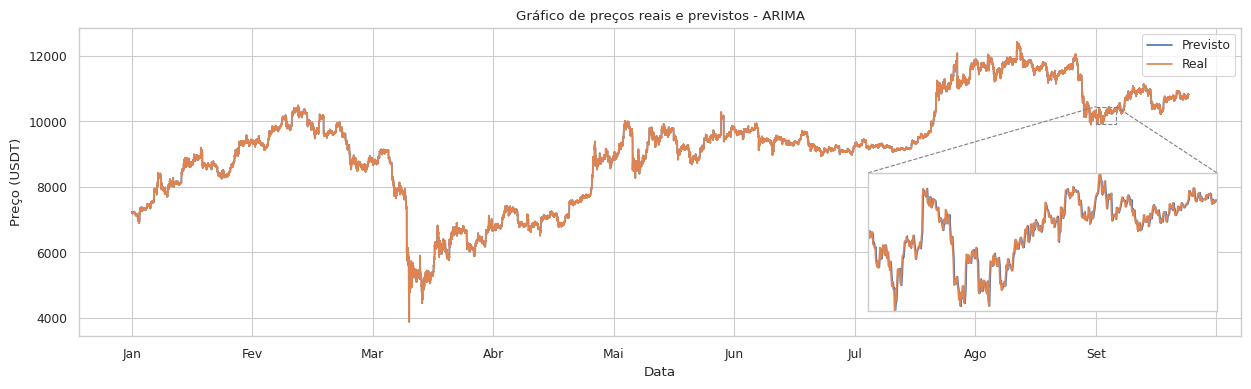

In [11]:
from matplotlib.ticker import MultipleLocator
# Configuração de tema Seaborn
sns.set_theme(rc={'figure.figsize': (15, 4)})
sns.set_style('whitegrid')
sns.set_context('paper')

# Criando o gráfico principal
ax = df_forecast.plot(y=['y_true', 'y_hat'])
ax.set_ylabel("Preço (USDT)")
ax.set_xlabel("Data")
ax.legend(["Previsto","Real",])
ax.set_title("Gráfico de preços reais e previstos - ARIMA")
ax.xaxis.set_major_locator(MultipleLocator(3000))
ax.set_xticklabels(['null','Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set'])  # Usando a coluna 'month' para rótulos

plt.grid(True)

zoom_start, zoom_end = 24000, 24500 

axins = inset_axes(ax, width="30%", height="45%", loc="lower right", borderpad=2)

df_forecast.iloc[zoom_start:zoom_end].plot(ax=axins, legend=False)

# Ajuste do eixo Y na lupa para uma melhor visualização
y_min = min(df_forecast['y_true'][zoom_start:zoom_end].min(), df_forecast['y_hat'][zoom_start:zoom_end].min()) - 0.1
y_max = max(df_forecast['y_true'][zoom_start:zoom_end].max(), df_forecast['y_hat'][zoom_start:zoom_end].max()) + 0.1
axins.set_ylim(y_min, y_max)
axins.set_xlim(zoom_start, zoom_end)

axins.set_xlabel('')
axins.set_ylabel('')
axins.set_xticks([])
axins.set_yticks([])

# Marcar a área da lupa no gráfico principal
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5", linestyle='--')

# Exibindo o gráfico final
plt.show()